# Safety vs Innovation Results Dashboard

This notebook visualizes the outputs generated by the runbook pipeline.

- Data splits in `data/processed`
- Polarization outputs in `results/polarization`
- Sanity metrics in `results/sanity`
- Ablation metrics in `results/pilot_ablation`


In [2]:
from pathlib import Path
import json
import statistics as stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_theme(style='whitegrid')
    HAS_SEABORN = True
except Exception:
    HAS_SEABORN = False

ROOT = Path('.').resolve()
DATA_DIR = ROOT / 'data' / 'processed'
RESULTS_DIR = ROOT / 'results'
POL_DIR = RESULTS_DIR / 'polarization'
ABL_DIR = RESULTS_DIR / 'pilot_ablation'
SANITY_DIR = RESULTS_DIR / 'sanity'
QUAL_DIR = RESULTS_DIR / 'qualitative'

LAYER = 16
TOPK = 20

print('ROOT:', ROOT)
print('Using layer:', LAYER)
print('Seaborn available:', HAS_SEABORN)


ROOT: C:\Users\23012\OneDrive\바탕 화면\[GRAIL]Exlpore_Agora\AI Forge
Using layer: 16
Seaborn available: True


In [3]:
def read_jsonl(path: Path):
    rows = []
    if not path.exists():
        return rows
    with path.open('r', encoding='utf-8-sig') as f:
        for line in f:
            line = line.strip()
            if line:
                rows.append(json.loads(line))
    return rows


def char_lengths(rows):
    return [len(str(r.get('text', ''))) for r in rows]


def safe_load_json(path: Path):
    if not path.exists():
        return None
    return json.loads(path.read_text(encoding='utf-8'))


def pretty_ci(ci):
    if not ci or len(ci) != 2:
        return 'n/a'
    return f"[{ci[0]:.4f}, {ci[1]:.4f}]"


## 1) Dataset Split Overview

In [4]:
split_files = {
    'dsafe_train': DATA_DIR / 'dsafe_train.jsonl',
    'dsafe_dev': DATA_DIR / 'dsafe_dev.jsonl',
    'dsafe_test': DATA_DIR / 'dsafe_test.jsonl',
    'dinnov_train': DATA_DIR / 'dinnov_train.jsonl',
    'dinnov_dev': DATA_DIR / 'dinnov_dev.jsonl',
    'dinnov_test': DATA_DIR / 'dinnov_test.jsonl',
}

rows_by_split = {k: read_jsonl(p) for k, p in split_files.items()}

summary_rows = []
for name, rows in rows_by_split.items():
    lens = char_lengths(rows)
    summary_rows.append({
        'split': name,
        'n': len(rows),
        'mean_chars': float(np.mean(lens)) if lens else np.nan,
        'p50_chars': float(np.percentile(lens, 50)) if lens else np.nan,
        'p90_chars': float(np.percentile(lens, 90)) if lens else np.nan,
    })

summary_df = pd.DataFrame(summary_rows).sort_values('split').reset_index(drop=True)
summary_df


,split,n,mean_chars,p50_chars,p90_chars
0,dinnov_dev,208,1250.990385,1163.0,2148.3
1,dinnov_test,226,1222.362832,1074.5,2236.0
2,dinnov_train,1232,1357.377435,1185.5,2457.6
3,dsafe_dev,119,1343.344538,1170.0,2763.4
4,dsafe_test,84,1283.011905,1209.0,2332.5
5,dsafe_train,569,1332.746924,1096.0,2609.2


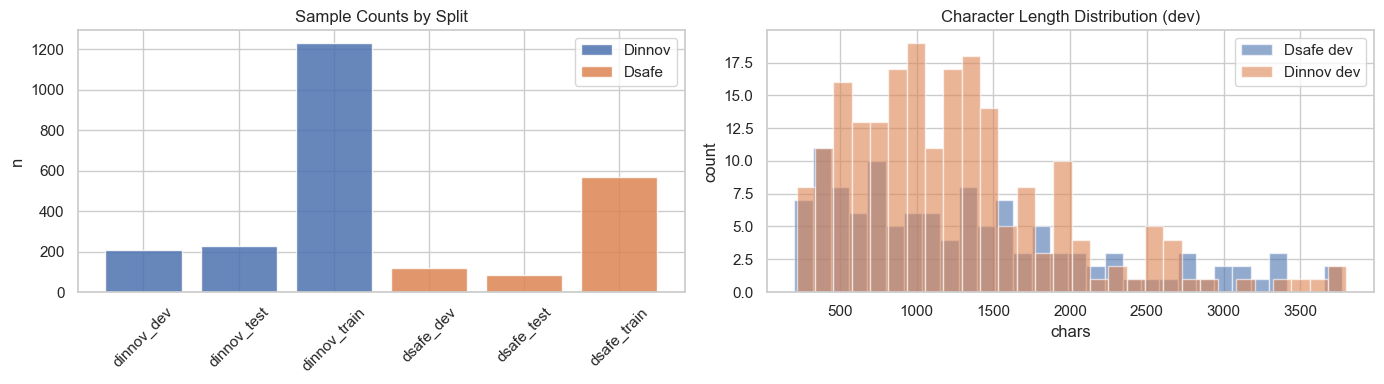

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Count bar plot
plot_df = summary_df.copy()
plot_df['group'] = plot_df['split'].apply(lambda x: 'Dsafe' if x.startswith('dsafe') else 'Dinnov')
plot_df['phase'] = plot_df['split'].str.split('_').str[1]

for group, gdf in plot_df.groupby('group'):
    axes[0].bar(gdf['split'], gdf['n'], label=group, alpha=0.85)
axes[0].set_title('Sample Counts by Split')
axes[0].set_ylabel('n')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()

# Length distribution on dev split
safe_dev = rows_by_split.get('dsafe_dev', [])
innov_dev = rows_by_split.get('dinnov_dev', [])
safe_l = char_lengths(safe_dev)
innov_l = char_lengths(innov_dev)

axes[1].hist(safe_l, bins=30, alpha=0.6, label='Dsafe dev')
axes[1].hist(innov_l, bins=30, alpha=0.6, label='Dinnov dev')
axes[1].set_title('Character Length Distribution (dev)')
axes[1].set_xlabel('chars')
axes[1].set_ylabel('count')
axes[1].legend()

plt.tight_layout()
plt.show()


## 2) Polarization (Layer-wise Feature Delta)

In [6]:
delta_path = POL_DIR / f'layer{LAYER}_delta.csv'

if not delta_path.exists():
    raise FileNotFoundError(f'Missing polarization CSV: {delta_path}')

delta_df = pd.read_csv(delta_path)
print('delta rows:', len(delta_df))
print('columns:', list(delta_df.columns))

delta_df.head()


delta rows: 16384
columns: ['feature_id', 'delta', 'mean_safe', 'mean_innov', 'std_safe', 'std_innov', 'effect_size_d']


,feature_id,delta,mean_safe,mean_innov,std_safe,std_innov,effect_size_d
0,8811,1.735523,7.937255,6.201732,9.750205,9.084737,0.185979
1,15978,1.191935,1.848395,0.656460,11.705032,6.176971,0.138516
2,15201,1.067388,1.353134,0.285746,8.449741,3.734999,0.180918
3,14077,1.047688,1.322695,0.275007,5.632873,2.901998,0.254973
4,1513,0.955403,2.417486,1.462083,4.944837,3.004501,0.249807


In [7]:
top_safe = delta_df.nlargest(TOPK, 'delta')[['feature_id', 'delta', 'mean_safe', 'mean_innov']]
top_innov = delta_df.nsmallest(TOPK, 'delta')[['feature_id', 'delta', 'mean_safe', 'mean_innov']]

print('Top safe features:')
display(top_safe)
print('Top innov features:')
display(top_innov)


Top safe features:


,feature_id,delta,mean_safe,mean_innov
0,8811,1.735523,7.937255,6.201732
1,15978,1.191935,1.848395,0.656460
2,15201,1.067388,1.353134,0.285746
3,14077,1.047688,1.322695,0.275007
4,1513,0.955403,2.417486,1.462083
5,13648,0.921602,1.073020,0.151418
6,4955,0.886317,1.043075,0.156759
7,3062,0.865736,0.971941,0.106205
8,10425,0.793827,0.943455,0.149629
9,10041,0.769388,0.867099,0.097711


Top innov features:


,feature_id,delta,mean_safe,mean_innov
16383,1033,-14.002624,40.747353,54.749977
16382,16028,-7.517658,5.316289,12.833947
16381,14125,-3.110392,3.368864,6.479256
16380,14919,-2.682493,0.305965,2.988458
16379,4500,-2.624977,0.000000,2.624977
16378,4631,-2.379943,5.177395,7.557338
16377,1428,-2.356747,5.578068,7.934815
16376,12895,-1.552436,4.865485,6.417921
16375,12224,-1.495541,4.800234,6.295775
16374,10480,-1.413331,5.541487,6.954819


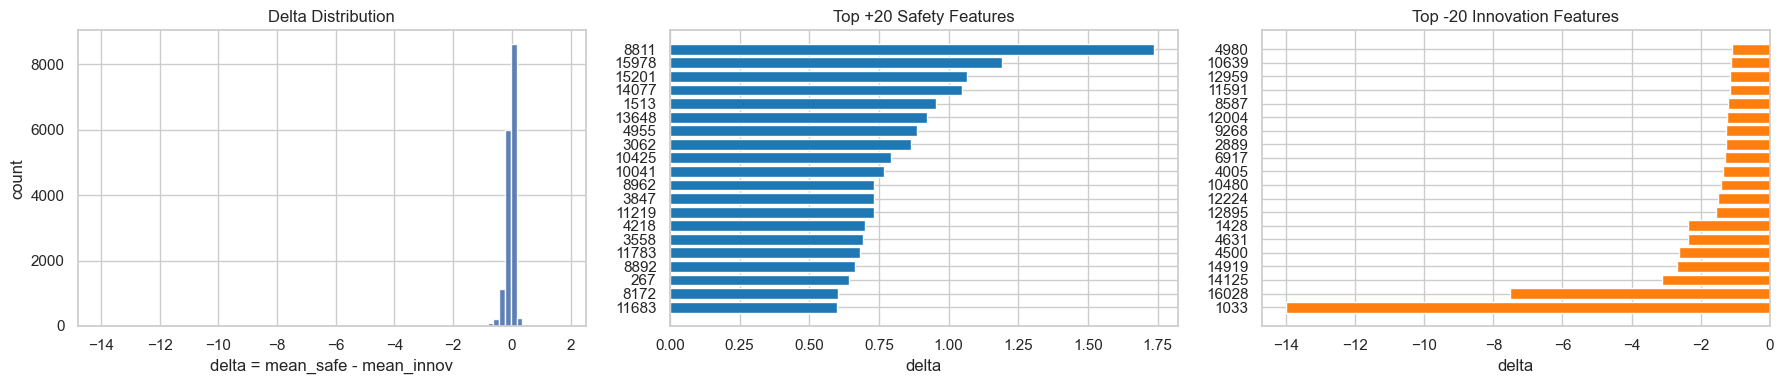

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Delta histogram
axes[0].hist(delta_df['delta'], bins=80, alpha=0.9)
axes[0].set_title('Delta Distribution')
axes[0].set_xlabel('delta = mean_safe - mean_innov')
axes[0].set_ylabel('count')

# Top positive
safe_plot = top_safe.sort_values('delta', ascending=True)
axes[1].barh(safe_plot['feature_id'].astype(str), safe_plot['delta'], color='tab:blue')
axes[1].set_title(f'Top +{TOPK} Safety Features')
axes[1].set_xlabel('delta')

# Top negative
innov_plot = top_innov.sort_values('delta', ascending=True)
axes[2].barh(innov_plot['feature_id'].astype(str), innov_plot['delta'], color='tab:orange')
axes[2].set_title(f'Top -{TOPK} Innovation Features')
axes[2].set_xlabel('delta')

plt.tight_layout()
plt.show()


## 3) Ablation Results

In [9]:
effect_summary_path = ABL_DIR / 'effect_summary.json'
effects_csv_path = ABL_DIR / f'effects_layer{LAYER}.csv'

effect_obj = safe_load_json(effect_summary_path)
if effect_obj is None:
    raise FileNotFoundError(f'Missing: {effect_summary_path}')

effect_summary = effect_obj.get('effect_summary', {})
print('n_samples:', effect_summary.get('n_samples'))
print('k_features:', effect_summary.get('k_features'))
print('mean_effect:', effect_summary.get('mean_effect'))
print('mean_effect_ci:', pretty_ci(effect_summary.get('bootstrap_95_ci')))
print('random_control_mean_effect:', effect_summary.get('random_control_mean_effect'))
print('random_control_ci:', pretty_ci(effect_summary.get('random_control_bootstrap_95_ci')))

if effects_csv_path.exists():
    effects_df = pd.read_csv(effects_csv_path)
else:
    # fallback if layer mismatch
    candidates = sorted(ABL_DIR.glob('effects_layer*.csv'))
    effects_df = pd.read_csv(candidates[-1]) if candidates else pd.DataFrame()

print('effects rows:', len(effects_df))
effects_df.head()


n_samples: 119
k_features: 64
mean_effect: -1.1097771139705883
mean_effect_ci: [-1.4351, -0.7811]
random_control_mean_effect: -0.9635963760504201
random_control_ci: [-1.2640, -0.6800]
effects rows: 119


,id,baseline_logprob,ablated_logprob,effect,random_ablated_logprob,random_effect
0,1032_2,-8.12500,-8.18750,0.06250,-8.43750,0.31250
1,1032_8,-11.62500,-9.37500,-2.25000,-7.68750,-3.93750
2,1054_1,-6.59375,-5.00000,-1.59375,-6.06250,-0.53125
3,1054_3,-18.62500,-18.50000,-0.12500,-18.25000,-0.37500
4,1125_4,-9.00000,-4.34375,-4.65625,-5.71875,-3.28125


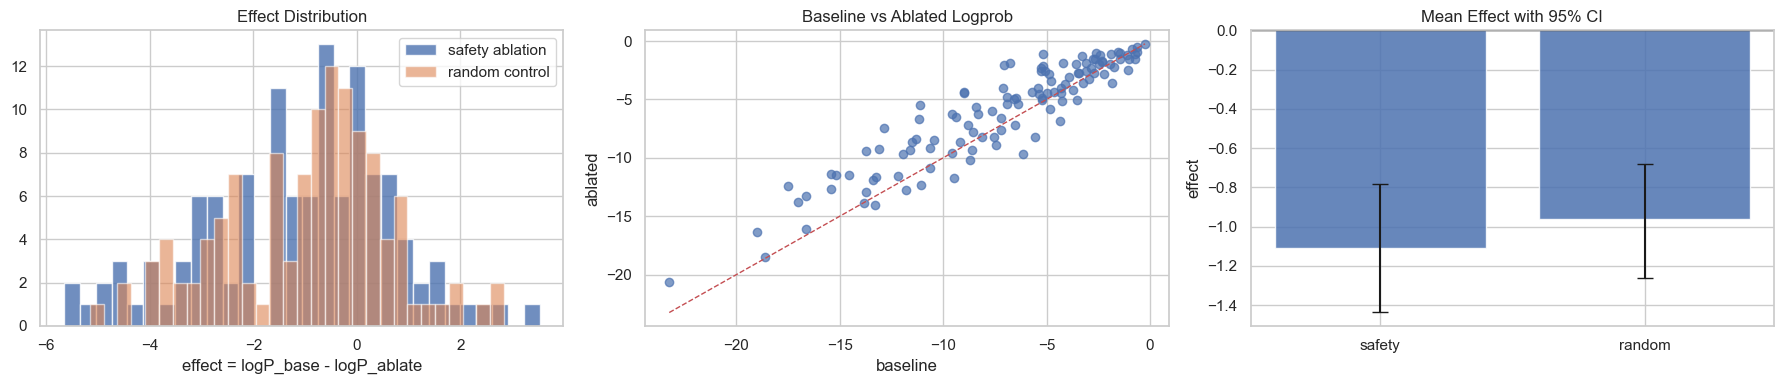

In [10]:
if len(effects_df) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    axes[0].hist(effects_df['effect'], bins=30, alpha=0.8, label='safety ablation')
    if 'random_effect' in effects_df.columns:
        axes[0].hist(effects_df['random_effect'], bins=30, alpha=0.6, label='random control')
    axes[0].set_title('Effect Distribution')
    axes[0].set_xlabel('effect = logP_base - logP_ablate')
    axes[0].legend()

    axes[1].scatter(effects_df['baseline_logprob'], effects_df['ablated_logprob'], alpha=0.7)
    min_v = min(effects_df['baseline_logprob'].min(), effects_df['ablated_logprob'].min())
    max_v = max(effects_df['baseline_logprob'].max(), effects_df['ablated_logprob'].max())
    axes[1].plot([min_v, max_v], [min_v, max_v], 'r--', lw=1)
    axes[1].set_title('Baseline vs Ablated Logprob')
    axes[1].set_xlabel('baseline')
    axes[1].set_ylabel('ablated')

    m = effect_summary.get('mean_effect', np.nan)
    ci = effect_summary.get('bootstrap_95_ci', [np.nan, np.nan])
    rm = effect_summary.get('random_control_mean_effect', np.nan)
    rci = effect_summary.get('random_control_bootstrap_95_ci', [np.nan, np.nan])

    means = np.array([m, rm], dtype=float)
    lower = means - np.array([ci[0], rci[0]], dtype=float)
    upper = np.array([ci[1], rci[1]], dtype=float) - means

    axes[2].bar(['safety', 'random'], means, yerr=[lower, upper], capsize=6, alpha=0.85)
    axes[2].axhline(0.0, color='black', lw=1)
    axes[2].set_title('Mean Effect with 95% CI')
    axes[2].set_ylabel('effect')

    plt.tight_layout()
    plt.show()
else:
    print('No effects CSV found.')


## 4) Sanity Metrics

In [11]:
sanity_path = SANITY_DIR / f'layer{LAYER}_sanity.json'
if not sanity_path.exists():
    # fallback to latest
    candidates = sorted(SANITY_DIR.glob('layer*_sanity.json'))
    sanity_path = candidates[-1] if candidates else None

if sanity_path is None or not sanity_path.exists():
    print('No sanity JSON found.')
    sanity = {}
else:
    sanity_obj = safe_load_json(sanity_path)
    sanity = sanity_obj.get('sanity', {})
    print('sanity file:', sanity_path)

print('quick_auc:', sanity.get('quick_auc'))
print('recommendation:', sanity.get('recommendation'))
print('length_confound:', sanity.get('length_confound'))

corr = pd.DataFrame(sanity.get('top_feature_length_correlations', []))
corr


sanity file: C:\Users\23012\OneDrive\바탕 화면\[GRAIL]Exlpore_Agora\AI Forge\results\sanity\layer16_sanity.json
quick_auc: 0.6330397543632837
recommendation: None
length_confound: {'mean_a': 310.4453781512605, 'var_a': 30544.588092864265, 'mean_b': 300.6682692307692, 'var_b': 21234.396669453734, 'mean_diff': 9.777108920491287}


,feature_id,pearson_corr_with_length
0,8811,0.395486
1,15978,0.025994
2,15201,-0.110822
3,14077,-0.022560
4,1513,0.153944
5,13648,-0.123701
6,4955,-0.110492
7,3062,0.070258
8,10425,0.019071
9,10041,-0.018339


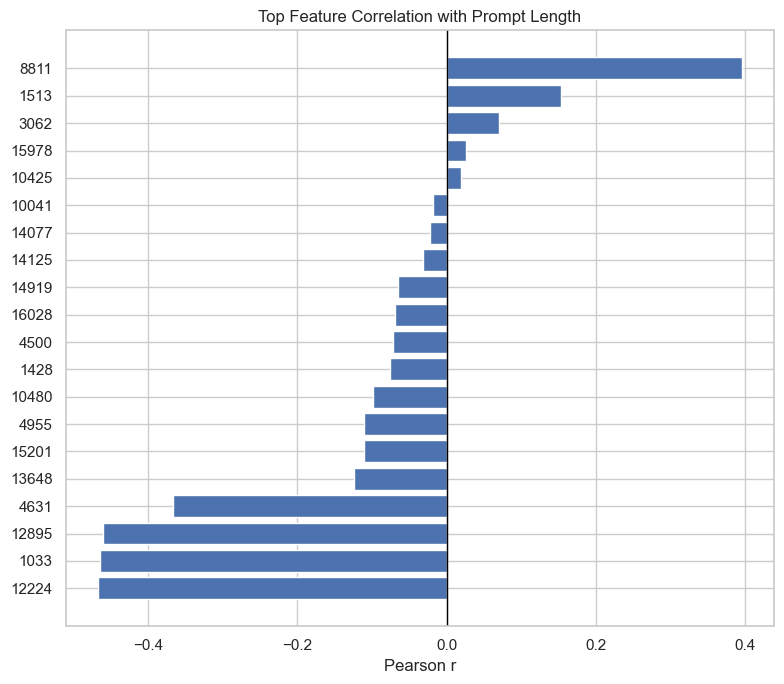

In [12]:
if 'corr' in globals() and len(corr) > 0:
    corr_plot = corr.sort_values('pearson_corr_with_length')
    plt.figure(figsize=(8, max(3, len(corr_plot) * 0.35)))
    plt.barh(corr_plot['feature_id'].astype(str), corr_plot['pearson_corr_with_length'])
    plt.axvline(0, color='black', lw=1)
    plt.title('Top Feature Correlation with Prompt Length')
    plt.xlabel('Pearson r')
    plt.tight_layout()
    plt.show()


## 5) Qualitative Examples Preview

In [13]:
qual_files = sorted(QUAL_DIR.glob('feature_*_top_examples.txt'))
print('qual files:', len(qual_files))

preview_n = 3
for p in qual_files[:preview_n]:
    print('\n' + '='*90)
    print(p.name)
    print('-'*90)
    txt = p.read_text(encoding='utf-8', errors='replace')
    print(txt[:1200])


qual files: 10

feature_10_top_examples.txt
------------------------------------------------------------------------------------------
Feature 10 top examples

[1] activation=0.243973
(c) Disrupting The Outbound Flow Of Firearms And Currency From The United States.—There is appropriated, out of any money in the Treasury not otherwise appropriated, for U.S. Customs and Border Protection for the fiscal year ending September 30, 2025, $285,000,000, to remain available until September 30, 2027, for increasing outbound inspection capabilities, including disrupting the flow of firearms and currency out of the United States, of which—
(1) $10,000,000 shall be for supporting the creation of a structured outbound inspection program within the Office of Field Operations that includes a comprehensive outbound inspection policy and performance metrics to measure the impact of outbound inspections; and
(2) $275,000,000 shall be for outbound inspections infrastructure projects at the land borders of

## 6) Quick Takeaways Template

Fill this section after reviewing the plots:

- Separation quality (AUC):
- Strongest polarized features (safe/innov):
- Ablation effect vs random control:
- Length confound risk:
- Recommended next layer(s):


## 7) Causal Sweep Summary (train->test)

Selection split is `train`, evaluation split is `test`. Primary metric is `safe_effect - random_effect` (paired delta).

In [ ]:

sweep_path = RESULTS_DIR / 'stats' / 'sweep_summary.csv'
if not sweep_path.exists():
    raise FileNotFoundError(f'Missing sweep summary: {sweep_path}')

sweep_df = pd.read_csv(sweep_path)
print('rows:', len(sweep_df))
print('layers:', sorted(sweep_df['layer'].unique().tolist()))
print('k values:', sorted(sweep_df['k'].unique().tolist()))

sweep_view = sweep_df.sort_values('mean_delta_safe_minus_random', ascending=False).copy()
sweep_view[['layer', 'k', 'mean_delta_safe_minus_random', 'delta_permutation_p']].head(12)


In [ ]:

plot_df = sweep_df.copy()
pivot_delta = plot_df.pivot(index='layer', columns='k', values='mean_delta_safe_minus_random').sort_index()
pivot_p = plot_df.pivot(index='layer', columns='k', values='delta_permutation_p').sort_index()

def p_to_star(p):
    if pd.isna(p):
        return ''
    if p < 1e-3:
        return '***'
    if p < 1e-2:
        return '**'
    if p < 5e-2:
        return '*'
    return ''

fig, ax = plt.subplots(figsize=(8.8, 5.2))
im = ax.imshow(pivot_delta.values, aspect='auto', cmap='coolwarm')
ax.set_title('Safe - Random Delta (train->test)')
ax.set_xlabel('k')
ax.set_ylabel('layer')
ax.set_xticks(np.arange(len(pivot_delta.columns)))
ax.set_xticklabels(pivot_delta.columns)
ax.set_yticks(np.arange(len(pivot_delta.index)))
ax.set_yticklabels(pivot_delta.index)

for i in range(pivot_delta.shape[0]):
    for j in range(pivot_delta.shape[1]):
        v = pivot_delta.values[i, j]
        p = pivot_p.values[i, j]
        star = p_to_star(p)
        txt = f'{v:.3f}{star}'
        ax.text(j, i, txt, ha='center', va='center', fontsize=8)

fig.colorbar(im, ax=ax, label='mean_delta_safe_minus_random')
plt.tight_layout()
plt.show()


In [ ]:

fig, ax = plt.subplots(figsize=(9, 4.8))
for layer, g in sweep_df.sort_values('k').groupby('layer'):
    ax.plot(g['k'], g['mean_delta_safe_minus_random'], marker='o', label=f'L{layer}')

ax.axhline(0.0, color='black', linewidth=1)
ax.set_title('Delta vs k by Layer')
ax.set_xlabel('k')
ax.set_ylabel('mean_delta_safe_minus_random')
ax.legend(ncol=4, fontsize=8)
plt.tight_layout()
plt.show()


## 8) L24 k-Sweep (Small-k Specificity)

Primary metric is `delta(safe-random)` with bootstrap 95% CI and permutation significance.

In [ ]:

l24_path = RESULTS_DIR / 'stats' / 'l24_k_focus_summary.csv'
if not l24_path.exists():
    raise FileNotFoundError(f'Missing L24 summary: {l24_path}')

l24_df = pd.read_csv(l24_path).sort_values('k')
l24_df


In [ ]:

fig, ax = plt.subplots(figsize=(8.2, 4.8))

y = l24_df['delta_safe_minus_random'].to_numpy()
yerr_low = y - l24_df['ci_low'].to_numpy()
yerr_high = l24_df['ci_high'].to_numpy() - y

ax.errorbar(
    l24_df['k'],
    y,
    yerr=[yerr_low, yerr_high],
    fmt='o-',
    capsize=4,
    linewidth=2,
    color='#1f77b4',
)
ax.axhline(0.0, color='black', linewidth=1)
ax.set_title('L24: delta(safe-random) vs k (95% CI)')
ax.set_xlabel('k')
ax.set_ylabel('delta_safe_minus_random')
ax.grid(True, alpha=0.3)

for _, r in l24_df.iterrows():
    ax.text(r['k'], r['delta_safe_minus_random'], f" {r['sig']}", va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## 9) Clamp: Cap vs Scale (L24, k=16/32)

Primary metric shown below is paired `safe-random` on `delta_prob_inc = P(INCENTIVE)_clamp - P(INCENTIVE)_base`.

In [ ]:

clamp_path = RESULTS_DIR / 'stats' / 'clamp_l24_cap_scale_summary.csv'
if not clamp_path.exists():
    raise FileNotFoundError(f'Missing clamp summary table: {clamp_path}')

clamp_cmp_df = pd.read_csv(clamp_path).sort_values(['k', 'mode', 'alpha'])
clamp_cmp_df.head(20)


In [ ]:

ks = sorted(clamp_cmp_df['k'].unique().tolist())
fig, axes = plt.subplots(1, len(ks), figsize=(6.0 * len(ks), 4.8), sharey=True)
if len(ks) == 1:
    axes = [axes]

for ax, k in zip(axes, ks):
    subk = clamp_cmp_df[clamp_cmp_df['k'] == k]
    for mode, gm in subk.groupby('mode'):
        gm = gm.sort_values('alpha')
        y = gm['mean_delta_safe_minus_random'].to_numpy()
        yerr_low = y - gm['ci_low'].to_numpy()
        yerr_high = gm['ci_high'].to_numpy() - y
        ax.errorbar(
            gm['alpha'],
            y,
            yerr=[yerr_low, yerr_high],
            fmt='o-',
            capsize=3,
            linewidth=2,
            label=mode,
        )
    ax.axhline(0.0, color='black', linewidth=1)
    ax.set_title(f'L24 clamp comparison (k={k})')
    ax.set_xlabel('alpha')
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel('paired delta (safe-random) on delta_prob_inc')
axes[-1].legend(loc='best')
plt.tight_layout()
plt.show()


In [ ]:

clamp_pivot = clamp_cmp_df.pivot_table(
    index=['k', 'mode'],
    columns='alpha',
    values='sig',
    aggfunc='first'
).reset_index()
clamp_pivot
